## Setup

### Libraries

In [53]:
import pandas as pd
import numpy as np
import swifter
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator, Fragments, Lipinski
from rdkit.Chem.Descriptors import rdMolDescriptors, MolLogP
from rdkit.Chem.rdchem import Mol
from sklearn.feature_selection import VarianceThreshold, chi2, mutual_info_classif, SelectKBest, SelectFpr, SelectFdr, SelectFwe, SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from typing import Callable, Tuple, Literal
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

## EDA

In [ ]:
full_train_set = pd.read_csv("../training_smiles.csv").set_index("INDEX")
full_train_set["MOL"] = full_train_set["SMILES"].swifter.apply(Chem.MolFromSmiles)
full_train_set = full_train_set.drop(columns=["SMILES"])
full_train_set.sample(10)

Pandas Apply:   0%|          | 0/208938 [00:00<?, ?it/s]

[16:17:01] WARNING: not removing hydrogen atom without neighbors


,ACTIVE,MOL
INDEX,,
49075,0.0,<rdkit.Chem.rdchem.Mol object at 0x000001EF15B...
194667,0.0,<rdkit.Chem.rdchem.Mol object at 0x000001EF160...
17788,0.0,<rdkit.Chem.rdchem.Mol object at 0x000001EF35C...
151996,0.0,<rdkit.Chem.rdchem.Mol object at 0x000001EEA98...
66425,0.0,<rdkit.Chem.rdchem.Mol object at 0x000001EF361...
192361,0.0,<rdkit.Chem.rdchem.Mol object at 0x000001EEA9C...
107115,0.0,<rdkit.Chem.rdchem.Mol object at 0x000001EC4CC...
22424,0.0,<rdkit.Chem.rdchem.Mol object at 0x000001EF35C...
131533,0.0,<rdkit.Chem.rdchem.Mol object at 0x000001EEA5B...


### Structural features

In [36]:
def fr_fluoro(mol: Mol) -> int:
    return sum(
        1
        for bond in mol.GetBonds()
        if bond.GetBeginAtom().GetAtomicNum() == 6  # Carbon
        and bond.GetEndAtom().GetAtomicNum() == 9  # Fluorine
    )


def fr_chloro(mol: Mol) -> int:
    return sum(
        1
        for bond in mol.GetBonds()
        if bond.GetBeginAtom().GetAtomicNum() == 6  # Carbon
        and bond.GetEndAtom().GetAtomicNum() == 17  # Chlorine
    )


def fr_arom_oxo(mol: Mol) -> int:
    return sum(
        1
        for bond in mol.GetBonds()
        if bond.GetBondTypeAsDouble() == 2  # Double bond
        and bond.GetBeginAtom().GetAtomicNum() == 6  # Carbon
        and bond.GetEndAtom().GetAtomicNum() == 8  # Oxygen
        and bond.GetBeginAtom().GetIsAromatic()  # Aromatic carbon
    )


def fr_alcohol(mol: Mol) -> int:
    return sum(
        1
        for bond in mol.GetBonds()
        if bond.GetBondTypeAsDouble() == 1  # Single bond
        and bond.GetBeginAtom().GetAtomicNum() == 8  # Oxygen
        and bond.GetEndAtom().GetAtomicNum() == 1  # Hydrogen
        and bond.GetEndAtom().GetIsAromatic() == False  # Non-aromatic oxygen
    )


def fr_alkene(mol: Mol) -> int:
    return sum(
        1
        for bond in mol.GetBonds()
        if bond.GetBondTypeAsDouble() == 2  # Double bond
        and bond.GetBeginAtom().GetAtomicNum() == 6  # Carbon
        and bond.GetEndAtom().GetAtomicNum() == 6  # Carbon
    )


def expand_structural_features(
    df: pd.DataFrame, radius: int = 3, vector_size: int = 1024
) -> pd.DataFrame:
    new_df = df.copy()
    mols = df["MOL"]

    # Functional groups
    new_df["n_amides"] = mols.swifter.apply(Fragments.fr_amide)
    new_df["n_ethers"] = mols.swifter.apply(Fragments.fr_ether)
    new_df["n_teramines"] = mols.swifter.apply(Fragments.fr_NH0)
    new_df["n_secamines"] = mols.swifter.apply(Fragments.fr_NH1)
    new_df["n_fluoros"] = mols.swifter.apply(fr_fluoro)
    new_df["n_chloros"] = mols.swifter.apply(fr_chloro)
    new_df["n_carboxacids"] = mols.swifter.apply(Fragments.fr_COO)
    new_df["n_oxos"] = mols.swifter.apply(fr_arom_oxo)
    new_df["n_alcohols"] = mols.swifter.apply(fr_alcohol)
    new_df["n_phenols"] = mols.swifter.apply(Fragments.fr_phenol)
    new_df["n_sulfoanamids"] = mols.swifter.apply(Fragments.fr_sulfonamd)
    new_df["n_priamines"] = mols.swifter.apply(Fragments.fr_NH2)
    new_df["n_nitriles"] = mols.swifter.apply(Fragments.fr_nitrile)
    new_df["n_alkenes"] = mols.swifter.apply(fr_alkene)
    new_df["n_anilines"] = mols.swifter.apply(Fragments.fr_aniline)
    new_df["n_halogens"] = mols.swifter.apply(Fragments.fr_halogen)
    new_df["n_alihydroxyls"] = mols.swifter.apply(Fragments.fr_Al_OH)
    new_df["n_arohydroxyls"] = mols.swifter.apply(Fragments.fr_Ar_OH)

    # ECFP
    ecfpgen = rdFingerprintGenerator.GetMorganGenerator(
        radius=radius, fpSize=vector_size
    )
    new_df["ecfp"] = mols.swifter.apply(
        lambda x: ecfpgen.GetFingerprintAsNumPy(x).tolist()
    )
    new_df = pd.concat(
        [
            new_df,
            pd.DataFrame(
                new_df["ecfp"].to_list(),
                index=new_df.index,
                columns=[f"ecfp_{i}" for i in range(vector_size)],
            ),
        ],
        axis=1,
    )
    new_df = new_df.drop(columns=["ecfp"])

    # Basic molecular information
    new_df["n_atoms"] = mols.swifter.apply(rdMolDescriptors.CalcNumAtoms)
    new_df["n_heavyatoms"] = mols.swifter.apply(rdMolDescriptors.CalcNumHeavyAtoms)
    new_df["n_bonds"] = mols.swifter.apply(lambda x: x.GetNumBonds())

    return new_df

In [ ]:
full_train_set = expand_structural_features(full_train_set)

Pandas Apply:   0%|          | 0/208938 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/208938 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/208938 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/208938 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/208938 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/208938 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/208938 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/208938 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/208938 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/208938 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/208938 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/208938 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/208938 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/208938 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/208938 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/208938 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/208938 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/208938 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/208938 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/208938 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/208938 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/208938 [00:00<?, ?it/s]

### Physicochemical properties

In [38]:
def expand_physicochemical_features(df: pd.DataFrame) -> pd.DataFrame:
    new_df = df.copy()
    mols = new_df["MOL"]

    # Weight
    new_df["exact_weight"] = mols.swifter.apply(rdMolDescriptors.CalcExactMolWt)
    # Lipophilicity
    new_df["log_p"] = mols.swifter.apply(MolLogP)
    # Hydrogen bonding capacity
    new_df["n_donors"] = mols.swifter.apply(Lipinski.NumHDonors)
    new_df["n_acceptors"] = mols.swifter.apply(Lipinski.NumHAcceptors)
    # Rotatable bonds
    new_df["n_rotbonds"] = mols.swifter.apply(rdMolDescriptors.CalcNumRotatableBonds)
    
    return new_df

In [ ]:
full_train_set = expand_physicochemical_features(full_train_set)

Pandas Apply:   0%|          | 0/208938 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/208938 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/208938 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/208938 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/208938 [00:00<?, ?it/s]

### Electronic properties

In [49]:
def expand_electronic_features(df: pd.DataFrame) -> pd.DataFrame:
    new_df = df.copy()
    mols = new_df["MOL"]

    # Polarity and charge
    new_df["TPSA"] = mols.swifter.apply(rdMolDescriptors.CalcTPSA) # Topological polar surface area
    # Aromatic rings
    new_df["n_arorings"] = mols.swifter.apply(rdMolDescriptors.CalcNumAromaticRings)

    return new_df

In [ ]:
full_train_set = expand_electronic_features(full_train_set)

Pandas Apply:   0%|          | 0/208938 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/208938 [00:00<?, ?it/s]

In [ ]:
full_train_set = full_train_set.drop(columns=["MOL"])
full_train_set.to_csv("./all_features.csv")

## Feature selection

In [80]:
full_train_set = pd.read_csv("./all_features.csv").set_index("INDEX")
train_set: pd.DataFrame
test_set: pd.DataFrame
train_set, test_set = train_test_split(full_train_set, test_size=0.3, random_state=20241209)
train_set.shape

(146256, 1053)

Remove features with 0 variance.

In [81]:
y = train_set["ACTIVE"]
X = train_set.drop(columns=["ACTIVE"])

fit = VarianceThreshold().fit(X, y)
train_set: pd.DataFrame = train_set[list(fit.get_feature_names_out()) + ["ACTIVE"]]

train_set.shape

(146256, 1052)

In [82]:
train_set = train_set.drop_duplicates(keep="first")
train_set.shape

(145307, 1052)

Scale the dataset.

In [83]:
X = train_set.drop(columns=["ACTIVE"])
y = train_set["ACTIVE"]

scaler = MinMaxScaler()

X = pd.DataFrame(scaler.fit_transform(X.values), columns=X.columns, index=X.index)
train_set = pd.concat([X, y], axis=1)
train_set.sample(10)

,n_amides,n_ethers,n_teramines,n_secamines,n_fluoros,n_chloros,n_carboxacids,n_oxos,n_phenols,n_sulfoanamids,...,n_heavyatoms,n_bonds,exact_weight,log_p,n_donors,n_acceptors,n_rotbonds,TPSA,n_arorings,ACTIVE
INDEX,,,,,,,,,,,,,,,,,,,,,
83138,0.000000,0.00,0.133333,0.000000,0.058824,0.000000,0.0,0.25,0.0,0.0,...,0.054381,0.062500,0.054252,0.616274,0.000000,0.078125,0.012658,0.016778,0.166667,0.0
37943,0.045455,0.10,0.000000,0.041667,0.000000,0.000000,0.0,0.00,0.0,0.0,...,0.075529,0.083333,0.068010,0.634132,0.027778,0.062500,0.025316,0.036866,0.083333,0.0
190674,0.000000,0.00,0.000000,0.020833,0.000000,0.000000,0.0,0.00,0.0,0.0,...,0.069486,0.077381,0.060937,0.649759,0.013889,0.046875,0.012658,0.022203,0.083333,0.0
100208,0.022727,0.00,0.133333,0.020833,0.000000,0.000000,0.0,0.00,0.0,0.0,...,0.057402,0.062500,0.053200,0.624767,0.013889,0.062500,0.025316,0.022564,0.166667,0.0
60140,0.000000,0.10,0.133333,0.000000,0.000000,0.000000,0.0,0.00,0.0,0.0,...,0.078550,0.086310,0.087908,0.615028,0.013889,0.125000,0.031646,0.054587,0.250000,0.0
116024,0.000000,0.00,0.266667,0.020833,0.000000,0.000000,0.0,0.00,0.0,0.0,...,0.072508,0.080357,0.063947,0.604604,0.013889,0.078125,0.050633,0.022713,0.166667,0.0
193278,0.022727,0.00,0.133333,0.020833,0.000000,0.222222,0.0,0.00,0.0,0.0,...,0.066465,0.071429,0.065623,0.646589,0.013889,0.046875,0.031646,0.026993,0.166667,0.0
201308,0.000000,0.05,0.133333,0.000000,0.000000,0.000000,0.0,0.00,0.0,0.0,...,0.066465,0.074405,0.057713,0.645729,0.000000,0.062500,0.025316,0.017389,0.250000,0.0
63642,0.068182,0.05,0.066667,0.041667,0.000000,0.000000,0.0,0.00,0.0,0.0,...,0.066465,0.068452,0.063922,0.593181,0.027778,0.093750,0.044304,0.046834,0.083333,0.0


In [84]:
ecfp_cols = [col for col in train_set.columns if col.startswith("ecfp")]
ecfp_set = train_set[ecfp_cols+["ACTIVE"]]
no_ecfp_set = train_set.drop(columns=ecfp_cols)

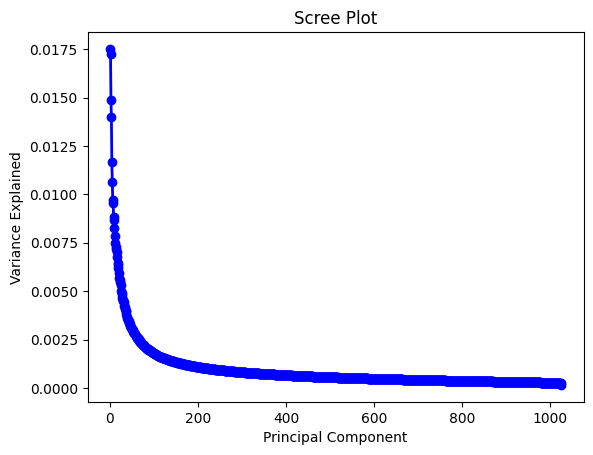

In [85]:
pca = PCA(len(ecfp_cols))
pca.fit(ecfp_set.drop(columns=["ACTIVE"]))

# The following code for the scree plot is taken from https://www.statology.org/scree-plot-python/
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, "o-", linewidth=2, color="blue")
plt.title("Scree Plot")
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained")
plt.show()

In [86]:
Z_ecfp = PCA(100).fit_transform(ecfp_set.drop(columns=["ACTIVE"]))
Z_ecfp = pd.DataFrame(Z_ecfp, index=train_set.index, columns=[f"z_ecfp_{i}" for i in range(100)])
pca_scaler = MinMaxScaler()
Z_ecfp = pd.DataFrame(pca_scaler.fit_transform(Z_ecfp.values), columns=Z_ecfp.columns, index=Z_ecfp.index)
train_set = pd.concat([train_set, Z_ecfp], axis=1).drop(columns=ecfp_cols)
train_set

,n_amides,n_ethers,n_teramines,n_secamines,n_fluoros,n_chloros,n_carboxacids,n_oxos,n_phenols,n_sulfoanamids,...,z_ecfp_90,z_ecfp_91,z_ecfp_92,z_ecfp_93,z_ecfp_94,z_ecfp_95,z_ecfp_96,z_ecfp_97,z_ecfp_98,z_ecfp_99
INDEX,,,,,,,,,,,,,,,,,,,,,
79927,0.022727,0.00,0.133333,0.041667,0.000000,0.000000,0.000000,0.00,0.0,0.00,...,0.370470,0.425426,0.475176,0.476579,0.625083,0.573975,0.511422,0.580873,0.606605,0.612377
34279,0.022727,0.05,0.133333,0.041667,0.000000,0.000000,0.000000,0.00,0.0,0.00,...,0.481140,0.514634,0.444000,0.308180,0.552945,0.573627,0.485492,0.447530,0.534337,0.551294
35282,0.045455,0.00,0.000000,0.041667,0.000000,0.000000,0.000000,0.00,0.0,0.00,...,0.578915,0.413551,0.507013,0.428374,0.530371,0.527458,0.457815,0.589371,0.481540,0.542317
170290,0.000000,0.00,0.066667,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.00,...,0.506564,0.510600,0.545582,0.460398,0.543595,0.504984,0.495176,0.670390,0.536231,0.559398
82998,0.000000,0.00,0.133333,0.020833,0.058824,0.000000,0.000000,0.00,0.0,0.00,...,0.601561,0.626687,0.441908,0.502046,0.518403,0.551087,0.414137,0.538711,0.560695,0.487505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102336,0.090909,0.00,0.133333,0.041667,0.000000,0.111111,0.000000,0.00,0.0,0.00,...,0.373184,0.325632,0.706696,0.436548,0.478562,0.505429,0.618698,0.501540,0.454270,0.468192
42656,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.00,...,0.445847,0.356166,0.584948,0.507288,0.659190,0.618963,0.414565,0.438726,0.317740,0.562382
80525,0.045455,0.05,0.066667,0.020833,0.000000,0.000000,0.142857,0.00,0.0,0.00,...,0.389150,0.483371,0.380369,0.557185,0.621910,0.580557,0.511279,0.676549,0.600490,0.500646


### Statistical selection

In [87]:
def statistically_relevant_features(
    df: pd.DataFrame,
    n_features: int = 10,
    p_value: float = 0.05,
    mode: Literal["nbest", "FPR", "FDR", "FWER"] = "nbest",
    score: Callable[[np.ndarray, np.ndarray], Tuple[np.ndarray, np.ndarray]] = chi2,
) -> pd.DataFrame:

    new_df = df.copy()

    y = new_df["ACTIVE"]

    X = new_df.drop(columns=["ACTIVE"])


    # get top 10 features by calculating correlation
    match mode:
        case "nbest":
            top_features = SelectKBest(score_func=score, k=n_features)
        case "FPR":
            top_features = SelectFpr(score_func=score, alpha=p_value)
        case "FDR":
            top_features = SelectFdr(score_func=score, alpha=p_value)
        case "FWER":
            top_features = SelectFwe(score_func=score, alpha=p_value)

    fit = top_features.fit(X, y)

    scores = pd.DataFrame(fit.scores_)

    columns = pd.DataFrame(X.columns)

    featureScores = pd.concat([columns, scores], axis=1)

    featureScores.columns = ["Feature", "Score"]


    # print features with the top 10 scores

    return featureScores.sort_values(by = "Score", axis=0, ascending=False)

In [89]:

modes = ["nbest", "FPR", "FDR", "FWER"]
for mode in modes:
    print(mode)
    result = statistically_relevant_features(train_set, score=mutual_info_classif, mode=mode)
    result.to_csv(f"{mode}.csv")
    display(result.head(10))

nbest


,Feature,Score
25,TPSA,0.025348
3,n_secamines,0.014137
26,n_arorings,0.011662
22,n_donors,0.010053
20,exact_weight,0.009505
0,n_amides,0.007910
13,n_anilines,0.007240
1,n_ethers,0.006664
2,n_teramines,0.006163
21,log_p,0.005704


FPR


,Feature,Score
25,TPSA,0.025121
3,n_secamines,0.014849
26,n_arorings,0.010188
20,exact_weight,0.009362
0,n_amides,0.008462
13,n_anilines,0.008040
22,n_donors,0.007142
1,n_ethers,0.006552
24,n_rotbonds,0.005965
2,n_teramines,0.005478


FDR


,Feature,Score
25,TPSA,0.025166
3,n_secamines,0.014832
26,n_arorings,0.010029
20,exact_weight,0.009636
22,n_donors,0.009169
0,n_amides,0.008073
1,n_ethers,0.007264
13,n_anilines,0.006805
23,n_acceptors,0.006025
2,n_teramines,0.005670


FWER


,Feature,Score
25,TPSA,0.025396
3,n_secamines,0.014407
26,n_arorings,0.010085
22,n_donors,0.010080
20,exact_weight,0.009851
0,n_amides,0.008520
13,n_anilines,0.008055
1,n_ethers,0.007225
2,n_teramines,0.006207
21,log_p,0.005216


We decide to reduce for now only the fingerprint features, considering only the 10 most relevant.

### Model-based selection

In [90]:
models = [
    LogisticRegression(),
    DecisionTreeClassifier(criterion="entropy"),
    ExtraTreesClassifier(criterion="entropy"),
    RandomForestClassifier(criterion="entropy"),
]

results = pd.DataFrame(index=train_set.drop(columns=["ACTIVE"]).columns)

def compute_score(X, y, selector):
    try:
        importance = np.absolute(selector.estimator_.coef_).squeeze()
    except AttributeError:
        importance = selector.estimator_.feature_importances_

    return selector,importance

for model in tqdm(models):
    y = train_set["ACTIVE"]
    X = train_set.drop(columns=["ACTIVE"])

    selector = SelectFromModel(model)
    selector = selector.fit(X, y)

    selector, importance = compute_score(X, y, selector)

    scores = pd.Series(data=importance, index=selector.feature_names_in_.squeeze())

    results[str(model)] = scores

results.to_csv(f"selectfrommodel_results.csv")
results

  0%|          | 0/4 [00:00<?, ?it/s]

,LogisticRegression(),DecisionTreeClassifier(criterion='entropy'),ExtraTreesClassifier(criterion='entropy'),RandomForestClassifier(criterion='entropy')
n_amides,2.113419,0.002506,0.010625,0.006547
n_ethers,1.569763,0.000803,0.006578,0.001960
n_teramines,1.518789,0.002346,0.008271,0.003296
n_secamines,1.013098,0.020442,0.013165,0.009564
n_fluoros,0.160867,0.000323,0.003437,0.000934
...,...,...,...,...
z_ecfp_95,1.457174,0.008189,0.007667,0.008185
z_ecfp_96,0.923550,0.008023,0.007546,0.007970
z_ecfp_97,0.396889,0.007241,0.007302,0.007855
z_ecfp_98,0.351211,0.009052,0.007288,0.007475


In [91]:
results = pd.DataFrame(MinMaxScaler().fit_transform(results), index=results.index, columns=results.columns)
results

,LogisticRegression(),DecisionTreeClassifier(criterion='entropy'),ExtraTreesClassifier(criterion='entropy'),RandomForestClassifier(criterion='entropy')
n_amides,0.438385,0.079699,0.525245,0.250769
n_ethers,0.325574,0.025554,0.282331,0.064313
n_teramines,0.314997,0.074606,0.383960,0.118627
n_secamines,0.210064,0.650174,0.677720,0.373406
n_fluoros,0.033223,0.010279,0.093775,0.022638
...,...,...,...,...
z_ecfp_95,0.302212,0.260460,0.347715,0.317336
z_ecfp_96,0.191482,0.255185,0.340419,0.308585
z_ecfp_97,0.082198,0.230294,0.325797,0.303920
z_ecfp_98,0.072720,0.287898,0.324962,0.288492


In [92]:
stats = pd.concat([results.mean(axis=1), results.std(axis=1)], axis=1)
stats.columns = ["importance_mean", "improtance_std"]
stats = stats.sort_values(by="importance_mean", axis=0, ascending=False)
stats.to_csv("selectfrommodel_summary.csv")
stats.head(10)

,importance_mean,improtance_std
z_ecfp_61,0.876939,0.246121
z_ecfp_3,0.688891,0.031319
log_p,0.686819,0.113694
n_alkenes,0.592396,0.305419
TPSA,0.549054,0.304765
z_ecfp_1,0.493952,0.093668
z_ecfp_26,0.489517,0.097998
z_ecfp_60,0.482409,0.080711
n_secamines,0.477841,0.225286
z_ecfp_68,0.416344,0.047529
